In [29]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [30]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("Data/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [31]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

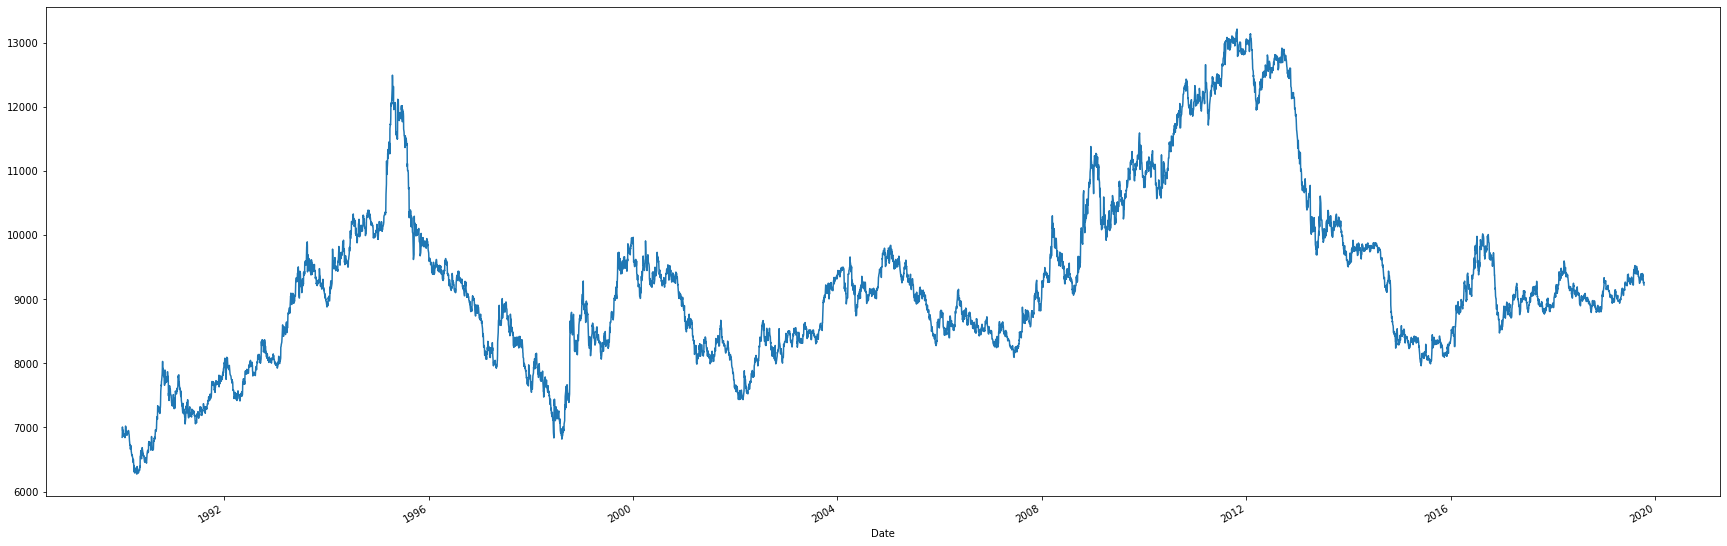

In [32]:
# Plot just the "Settle" column from the dataframe:
yen_futures['Settle'].plot(figsize=(30,10))

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [33]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
yf_noise, yf_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])
yf_noise

Date
1990-01-02   -61.503967
1990-01-03   -21.799756
1990-01-04    98.942896
1990-01-05    40.776052
1990-01-08    49.689938
                ...    
2019-10-09    24.939247
2019-10-10    -5.868559
2019-10-11   -54.454594
2019-10-14   -36.423060
2019-10-15   -75.844123
Name: Settle_cycle, Length: 7515, dtype: float64

In [34]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
combined = yen_futures['Settle']
combined = pd.concat([combined, yf_trend, yf_noise], axis="columns", join="inner")
combined.head()

,Settle,Settle_trend,Settle_cycle
Date,,,
1990-01-02,6847.0,6908.503967,-61.503967
1990-01-03,6887.0,6908.799756,-21.799756
1990-01-04,7008.0,6909.057104,98.942896
1990-01-05,6950.0,6909.223948,40.776052
1990-01-08,6959.0,6909.310062,49.689938


<AxesSubplot:xlabel='Date'>

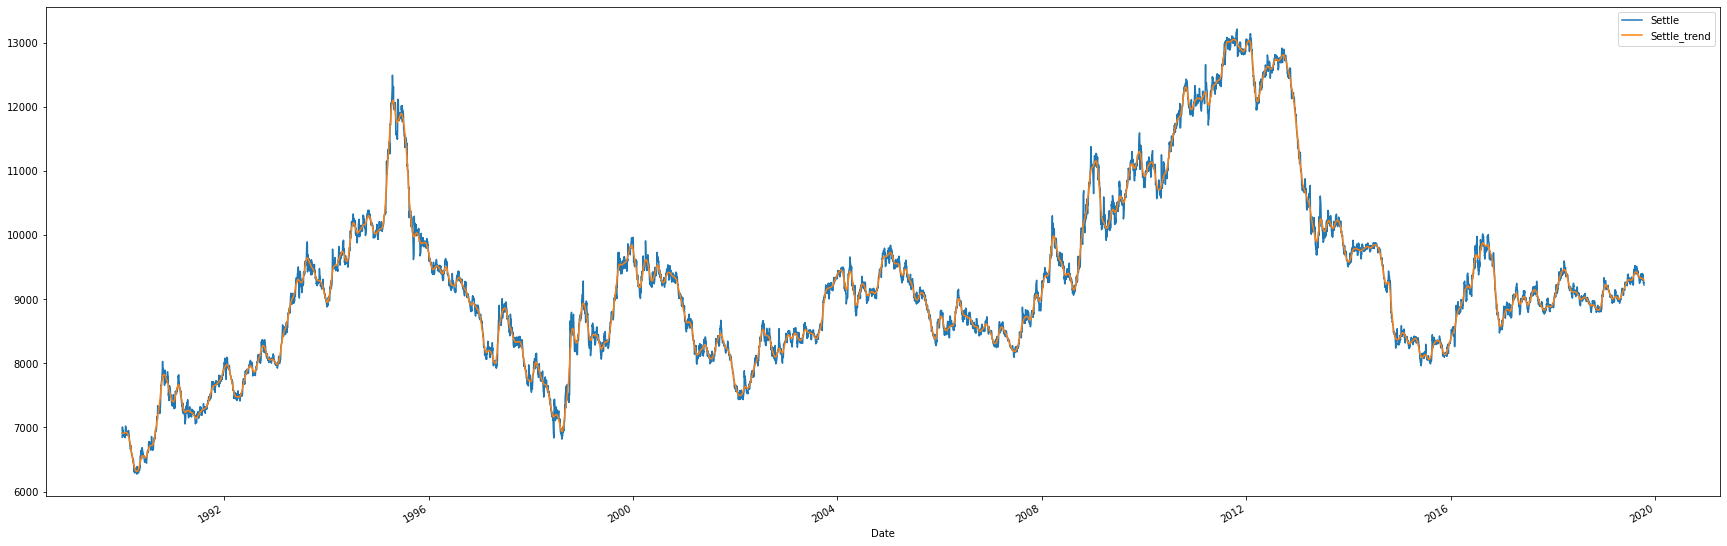

In [35]:
# Plot the Settle Price vs. the Trend for 2015 to the present
combined[['Settle','Settle_trend']].plot(figsize=(30,10))

<AxesSubplot:xlabel='Date'>

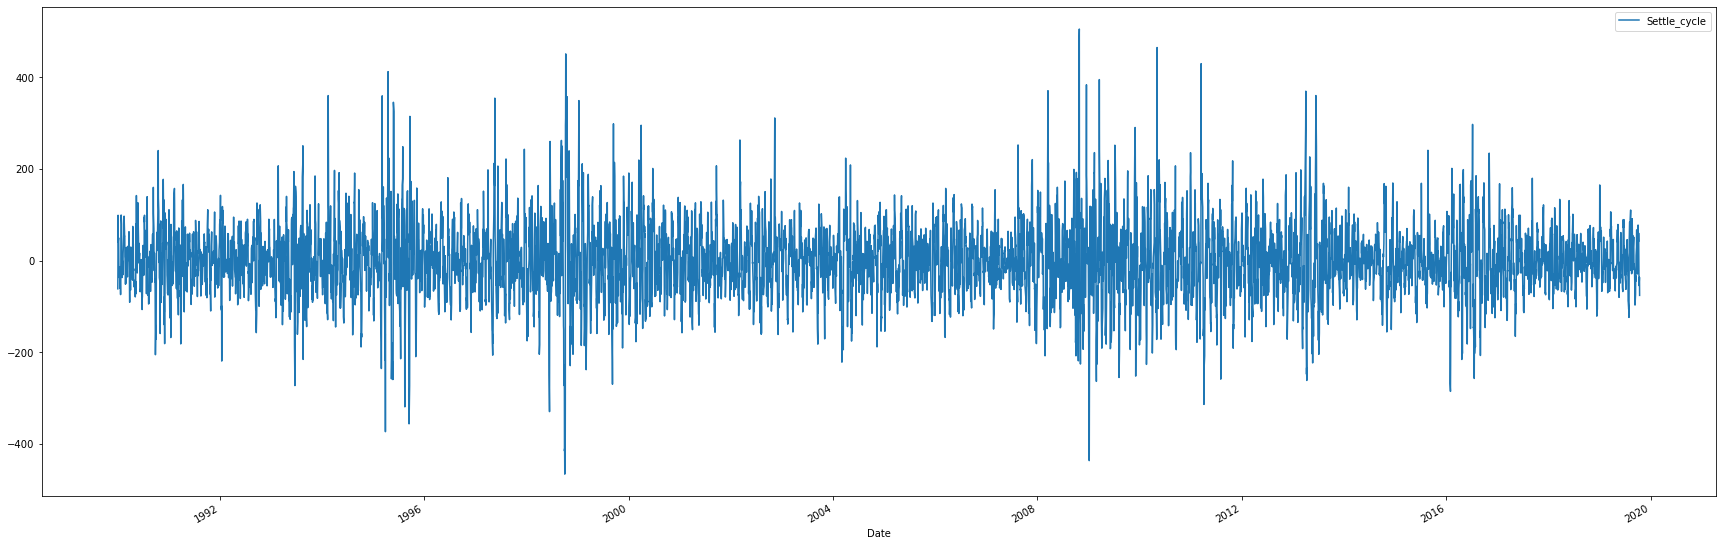

In [36]:
# Plot the Settle Noise
combined[['Settle_cycle']].plot(figsize=(30,10))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [67]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [68]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns['Settle'], order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()


C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, bu

In [69]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 18 Oct 2021   AIC                          15798.142
Time:                        20:23:14   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3353           +0.0000j            3.3353            0.5000
AR.2         -157.2097           +0.0000j          157.2097            0.5000
MA.1           -3.3942           +0.0000j            3.3942            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

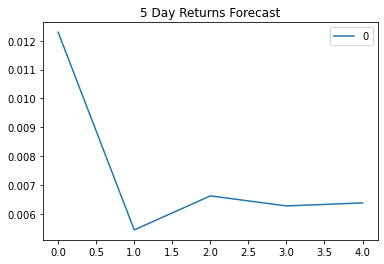

In [70]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [71]:
 from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arima_model = ARIMA(returns['Settle'], order=(5,1,1))

# Fit the model
results_arima = arima_model.fit()

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, bu

In [72]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7513
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7895.738
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 18 Oct 2021   AIC                          15807.476
Time:                        20:23:27   BIC                          15862.871
Sample:                             1   HQIC                         15826.497
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.196e-06   3.62e-06     -0.883      0.377   -1.03e-05     3.9e-06
ar.L1.D.Settle    -0.0132      0.012     -1.141      0.254      -0.036       0.009
ar.L2.D.Settle    -0.0021      0.012     -0.183      0.855      -0.025       0.021
ar.L3.D.Settle    -0.0128      0.012     -1.105      0.269      -0.035       0.010
ar.L4.D.Settle    -0.0212      0.012     -1.840      0.066      -0.044       0.001
ar.L5.D.Settle     0.0027      0.012      0.234      0.815      -0.020       0.025
ma.L1.D.Settle    -0.9999      0.000  -2366.672      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9319           -1.6324j            2.5292           -0.3883
AR.2           -1.9319           +1.6324j            2.5292            0.3883
AR.3            1.6096           -2.0521j            2.6081           -0.1441
AR.4            1.6096           +2.0521j            2.6081            0.1441
AR.5            8.5052           -0.0000j            8.5052           -0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

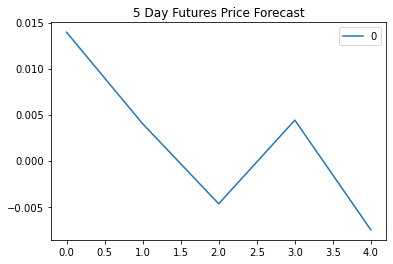

In [73]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [74]:
from arch import arch_model

In [75]:
# Estimate a GARCH model:
model = arch_model(returns.Settle, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model.fit(disp="off")

In [76]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Mon, Oct 18 2021   Df Residuals:                     7514
Time:                        20:23:36   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [58]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [59]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

C:\Users\Jay Cao\Anaconda3\envs\pyvizenv\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [60]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [61]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


<AxesSubplot:>

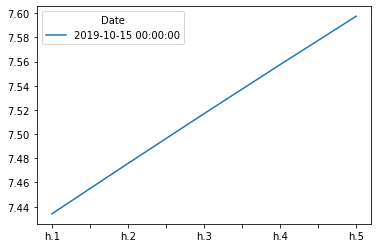

In [77]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

In [64]:
print("Answer 1: Based on the ARMA and ARIMA modelling, now is not the time to buy the Yen")
print("Answer 2: the risk of the Yen is expected to increase based on the GARCH model")
print("Answer 3: No I would not be confident using these models for trading as the P value is very high (not close to 0) and the GARCH prediction is going to increase.")

Answer 1: Based on the ARMA and ARIMA modelling, now is not the time to buy the Yen
Answer 2: the risk of the Yen is expected to increase based on the GARCH model
Answer 3: No I would not be confident using these models for trading as the P value is very high (not close to 0) and the GARCH prediction is going to increase.
